In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Inspect basic information
print("Data Shape:", data.shape)  # Check the shape of the dataset (rows and columns)
print("Columns:", data.columns)  # Check column names
print("Class Distribution:\n", data['Class'].value_counts())  # Check target variable distribution
print("Missing Values:\n", data.isnull().sum())  # Check for missing values

# View the first few rows of the data
print(data.head())

Data Shape: (284807, 31)
Columns: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0

/var/folders/dk/l7jv_8q12d797j88b290p2kw0000gn/T/ipykernel_55774/3778579891.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data, palette='Set2')


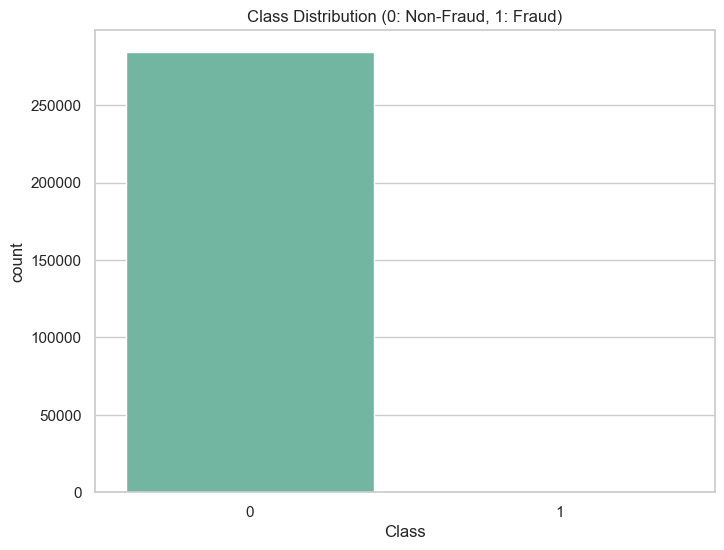

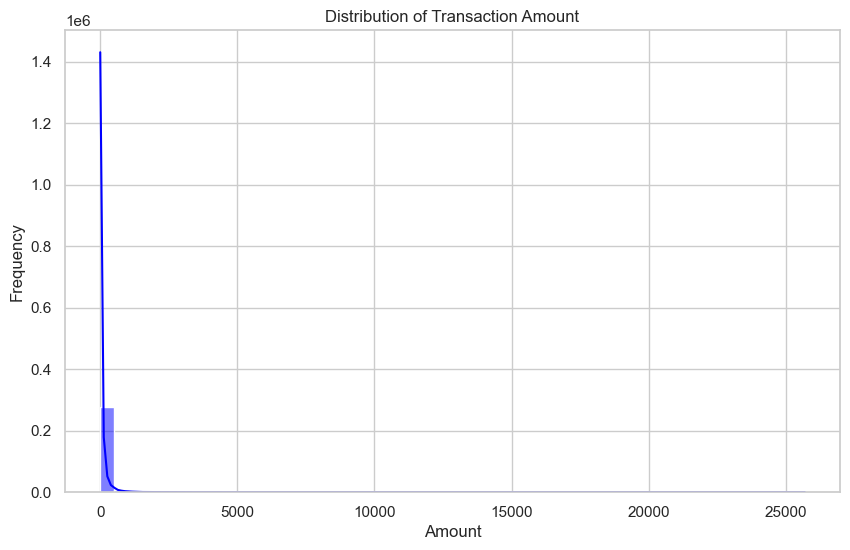

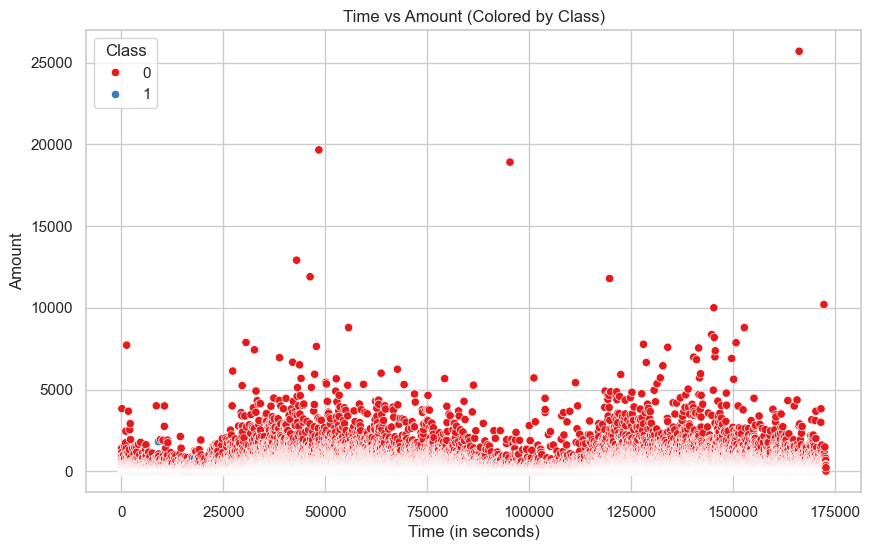

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data, palette='Set2')
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

# Plot transaction amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Plot time vs. amount (colored by class)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=data, palette='Set1')
plt.title('Time vs Amount (Colored by Class)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize 'Time' and 'Amount'
scaler = StandardScaler()
data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Check the standardized data
print(data[['Time', 'Amount']].head())

       Time    Amount
0 -1.996583  0.244964
1 -1.996583 -0.342475
2 -1.996562  1.160686
3 -1.996562  0.140534
4 -1.996541 -0.073403


In [4]:
import numpy as np

# Extract hour of the day and day of the week
data['Hour'] = data['Time'] % 24  # Hour of the day (0-23)
data['Day'] = (data['Time'] // 24) % 7  # Day of the week (0 = Monday, 6 = Sunday)

# Calculate hourly transaction frequency
hourly_freq = data.groupby('Hour').size().reset_index(name='Hourly_Frequency')
data = data.merge(hourly_freq, on='Hour', how='left')

# Check the new features
print(data[['Time', 'Hour', 'Day', 'Hourly_Frequency']].head())

       Time       Hour  Day  Hourly_Frequency
0 -1.996583  22.003417  6.0                 2
1 -1.996583  22.003417  6.0                 2
2 -1.996562  22.003438  6.0                 2
3 -1.996562  22.003438  6.0                 2
4 -1.996541  22.003459  6.0                 2


In [5]:
if 'Latitude' in data.columns and 'Longitude' in data.columns:
    # Calculate distance from a reference location (e.g., user's home)
    from geopy.distance import geodesic

    reference_location = (40.7128, -74.0060)  # Example: New York City
    data['Distance_From_Home'] = data.apply(
        lambda row: geodesic((row['Latitude'], row['Longitude']), reference_location).km, axis=1
    )

    # Check the new feature
    print(data[['Latitude', 'Longitude', 'Distance_From_Home']].head())

In [6]:
# Features (X) and target (y)
X = data.drop(columns=['Class'])  # Drop the target column
y = data['Class']  # Target variable

print("Features Shape:", X.shape)
print("Target Shape:", y.shape)

Features Shape: (284807, 33)
Target Shape: (284807,)


In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (227845, 33)
Testing Data Shape: (56962, 33)


In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Resampled Training Data Shape:", X_res.shape)
print("Resampled Target Distribution:\n", y_res.value_counts())

Resampled Training Data Shape: (454902, 33)
Resampled Target Distribution:
 Class
0    227451
1    227451
Name: count, dtype: int64


### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_res, y_res)  # Use SMOTE-resampled data

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.94      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Logistic Regression AUC-ROC: 0.9559697753609042


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### XGBoost

In [12]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_res, y_res)

# Evaluate
y_pred = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost AUC-ROC: 0.923284736657747


### Train Unsupervised Models

### Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Contamination = % of outliers
iso_forest.fit(X_train)  # Use original training data (no labels)

# Predict anomalies (1 = normal, -1 = anomaly)
y_pred = iso_forest.predict(X_test)
y_pred = [1 if x == -1 else 0 for x in y_pred]  # Convert to binary labels

# Evaluate
print("Isolation Forest Classification Report:\n", classification_report(y_test, y_pred))
print("Isolation Forest AUC-ROC:", roc_auc_score(y_test, y_pred))

Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.54      0.15        98

    accuracy                           0.99     56962
   macro avg       0.54      0.77      0.57     56962
weighted avg       1.00      0.99      0.99     56962

Isolation Forest AUC-ROC: 0.765712749646848


### One-Class SVM

In [17]:
from sklearn.svm import OneClassSVM

# Train One-Class SVM
oc_svm = OneClassSVM(nu=0.01)  # nu = % of outliers
oc_svm.fit(X_train)  # Use original training data (no labels)

# Predict anomalies (1 = normal, -1 = anomaly)
y_pred = oc_svm.predict(X_test)
y_pred = [1 if x == -1 else 0 for x in y_pred]  # Convert to binary labels

# Evaluate
print("One-Class SVM Classification Report:\n", classification_report(y_test, y_pred))
print("One-Class SVM AUC-ROC:", roc_auc_score(y_test, y_pred))

One-Class SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.62      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.81      0.59     56962
weighted avg       1.00      0.99      0.99     56962

One-Class SVM AUC-ROC: 0.8065026974492668


### Best Model: XGBoost

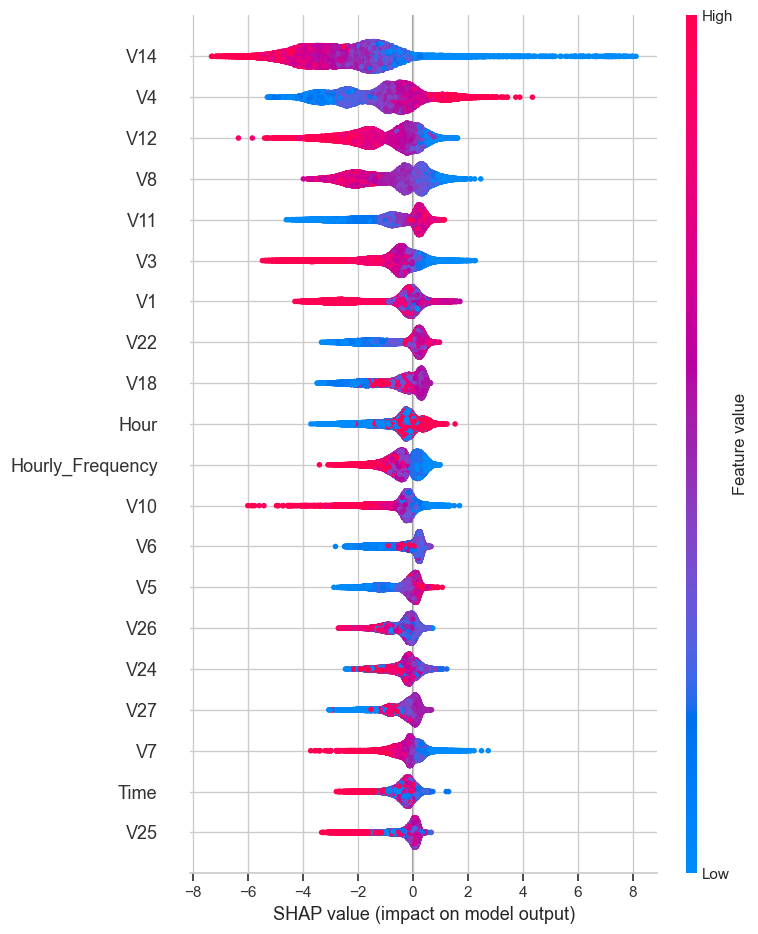

In [19]:
import shap

# Explain XGBoost model using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)

In [20]:
import joblib

# Save the model
joblib.dump(xgb, 'best_fraud_detection_model.pkl')

# Load the model
loaded_model = joblib.load('best_fraud_detection_model.pkl')